In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Load the USEEIO data

# Direct + indirect flow coefficients size: 
M = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='M', index_col=0) # 2721 x 411
# Direct + indirect impact coefficients
N = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='N', index_col=0) # 23 x 411
# Flow coefficient matrix (Satellite) matrix 
B = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='B', index_col=0) # 2721 x 411
# Direct impact coefficients
D = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='D', index_col=0) # 2721 x 411
# Industry output
x = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='x', index_col=0) # 411 x 1
# Commodity output
q = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='q', index_col=0) # 411 x 1


# Flows
Bx = B@np.diag(x["x"].values) # 2721 x 411
Bx.columns = B.columns
# Impacts
Dx = D@np.diag(x["x"].values) # 2721 x 411
Dx.columns = D.columns

Mx = M@np.diag(x["x"].values)
Mx.columns = M.columns

Nx = N@np.diag(x["x"].values)
Nx.columns = N.columns


# environmental flows
meta_env_flows = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='flows', index_col=0) # 2721 x 1
# impact indicators
meta_indicators = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='indicators', index_col=0) # 23 x 1
# commodities
meta_sector_names = pd.read_excel('data/USEEIOv2.0.1-411.xlsx', sheet_name='commodities_meta', index_col=0) # 411 x 1





In [58]:
def get_text_between_colon_and_slash(text):
    if pd.isna(text):  # Handle NaN values
        return text
    
    if ":" in text and "/" in text:
        # Get text between first ":" and first "/"
        return text.split(":", 1)[1].split("/", 1)[0].strip()
    elif ":" in text:
        # If only ":" exists, get everything after it
        return text.split(":", 1)[1].strip()
    elif "/" in text:
        # If only "/" exists, get everything before it
        return text.split("/", 1)[0].strip()
    return text

# Apply to your series
cleaned_categories = meta_sector_names.loc[:,"Category"].apply(get_text_between_colon_and_slash)


mi = pd.MultiIndex.from_arrays([meta_sector_names["ID"], meta_sector_names["Name"],
 meta_sector_names["Category"], cleaned_categories], names=['ID', 'name', 'category', 'aggregated_categories'])
Bx.columns = mi
Dx.columns = mi
Mx.columns = mi
Nx.columns = mi

In [20]:
env_vars = ["Energy Use", "Greenhouse Gases", "Freshwater withdrawals"]
sector_codes = ["334413/US", "334418/US", "33441A/US"]
sec_name = "31-33: Manufacturing/3344: Semiconductor and Other Electronic Component Manufacturing"

In [36]:
# lets calculate share of env vars in sector
tmp = Dx.T / Dx.T.sum(axis=0) * 100
# lets calculate share of env vars in sector
tmp.groupby(level='category').sum().loc[sec_name, env_vars]

Energy Use                0.000002
Greenhouse Gases          0.025603
Freshwater withdrawals    0.097461
Name: 31-33: Manufacturing/3344: Semiconductor and Other Electronic Component Manufacturing, dtype: float64

In [37]:
# lets calculate share of env vars in sector
tmp = Nx.T / Nx.T.sum(axis=0) * 100
# lets calculate share of env vars in sector
tmp.groupby(level='category').sum().loc[sec_name, env_vars]

Energy Use                0.071641
Greenhouse Gases          0.113928
Freshwater withdrawals    0.125167
Name: 31-33: Manufacturing/3344: Semiconductor and Other Electronic Component Manufacturing, dtype: float64

NameError: name 'plt' is not defined

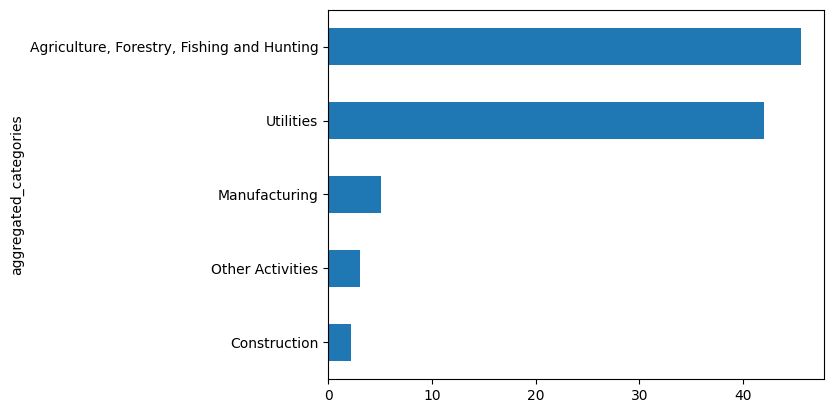

In [78]:
# can you normalize by aggregated categories? 
(Dx.loc["Freshwater withdrawals"].groupby(level='aggregated_categories').sum().div(Dx.loc["Freshwater withdrawals"].sum()) * 100).sort_values().tail(5).plot.barh()


<Axes: ylabel='category'>

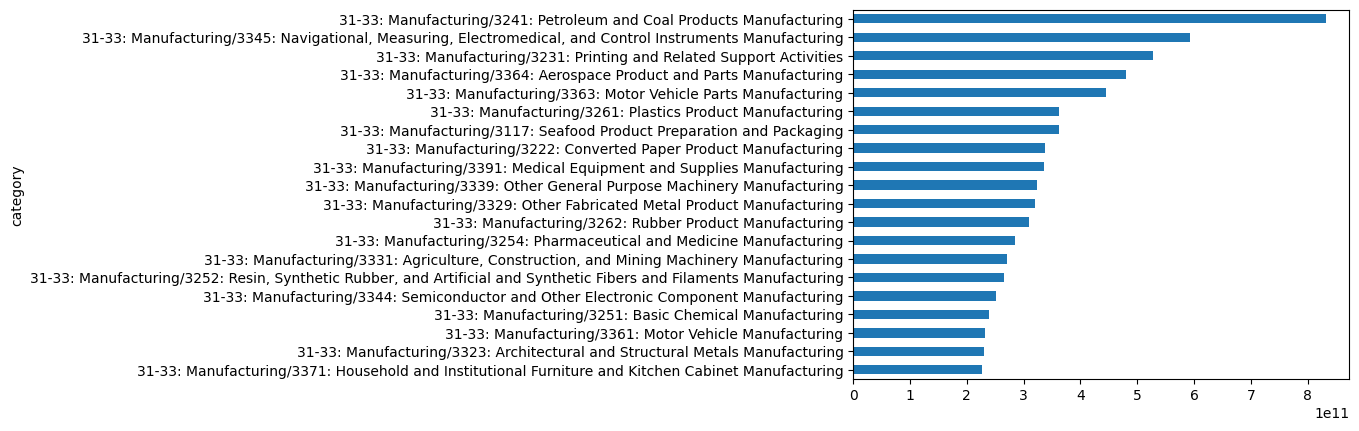

In [74]:
Dx.loc["Freshwater withdrawals"].loc[slice(None), 
slice(None), slice(None), "Manufacturing"].groupby(level="category").sum().sort_values().tail(20).plot.barh()

<Axes: title={'center': 'Freshwater Withdrawals in the US by sector'}, xlabel='Percentage of Total Freshwater Withdrawals (%)', ylabel=' '>

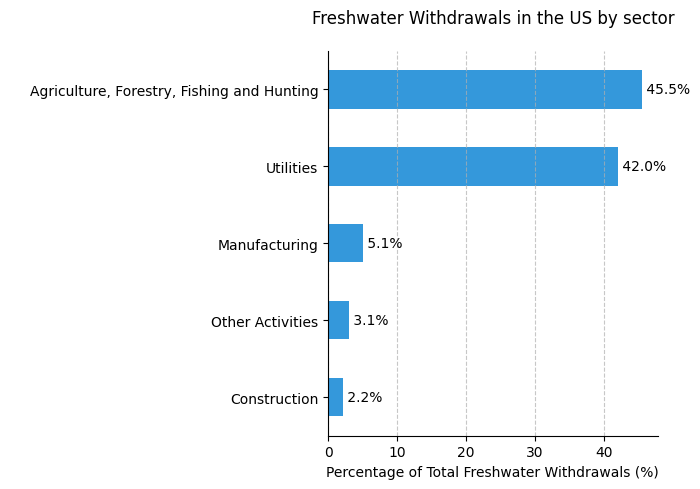

In [96]:
def plot_beautiful_bars(data, title=None, xlabel=None, color='#3498db', figsize=(7, 5), labels=False):
    """
    Create a beautiful horizontal bar chart with customizable features
    
    Parameters:
    - data: Series or DataFrame to plot
    - title: str, chart title
    - xlabel: str, x-axis label
    - color: str, bar color
    - figsize: tuple, figure size
    - labels: bool, whether to show value labels on bars
    """
    # Create figure and axis
    plt.figure(figsize=figsize)
    ax = data.plot(kind='barh', color=color)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Customize grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add value labels if requested
    if labels:
        for i, v in enumerate(data):
            ax.text(v, i, f' {v:.1f}%', va='center')
    
    # Customize title and labels
    if title:
        plt.title(title, pad=20)
    if xlabel:
        plt.xlabel(xlabel)

    plt.ylabel(' ')
    
    # Adjust layout
    plt.tight_layout()
    
    return ax

# Example usage:
data = (Dx.loc["Freshwater withdrawals"].groupby(level='aggregated_categories').sum().div(Dx.loc["Freshwater withdrawals"].sum()) * 100).sort_values().tail(5)


plot_beautiful_bars(
    data,
    title='Freshwater Withdrawals in the US by sector',
    xlabel='Percentage of Total Freshwater Withdrawals (%)',
    labels=True
)

/var/folders/xk/nbnx17251fjc0fr2c924xwsw0000gn/T/ipykernel_40714/2265156506.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Axes: title={'center': 'Freshwater Withdrawals in the US Manufacturing sector'}, xlabel='Percentage of Total Freshwater Withdrawals in Manufacturing (%)', ylabel=' '>

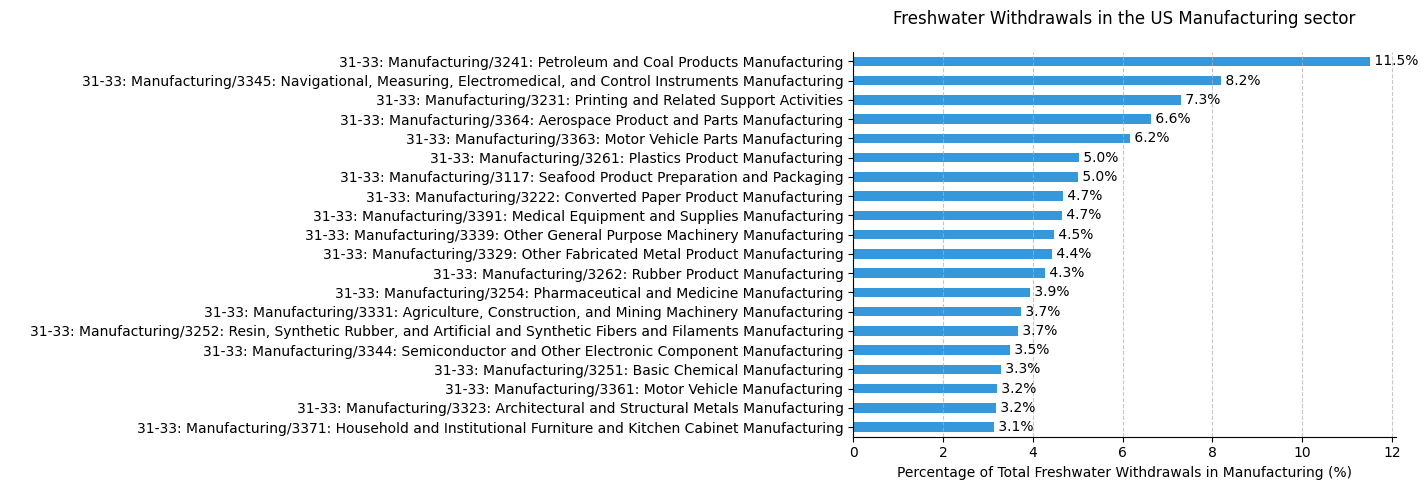

In [98]:
data =Dx.loc["Freshwater withdrawals"].loc[slice(None), 
slice(None), slice(None), "Manufacturing"].groupby(level="category").sum().sort_values().tail(20)
data = data.div(data.sum()) * 100

plot_beautiful_bars(
    data,
    title='Freshwater Withdrawals in the US Manufacturing sector',
    xlabel='Percentage of Total Freshwater Withdrawals in Manufacturing (%)',
    labels=True
)


In [57]:
cleaned_categories

Index
0      Agriculture, Forestry, Fishing and Hunting
1      Agriculture, Forestry, Fishing and Hunting
2      Agriculture, Forestry, Fishing and Hunting
3      Agriculture, Forestry, Fishing and Hunting
4      Agriculture, Forestry, Fishing and Hunting
                          ...                    
406                              Other Activities
407                              Other Activities
408                              Other Activities
409                              Other Activities
410                              Other Activities
Name: Category, Length: 411, dtype: object